In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from openpose import run_openpose, load_frame, load_keypoints
from preprocess import trim_zero, interpolate_zero, median5mean3Filter
from segmentation import cluster
from visualize import plot_cluster

In [3]:
'''
run and load openpose frames
'''

'\nrun and load openpose frames\n'

In [4]:
filename = 'parkinson-1'

In [7]:
run_openpose('mdcu-test', filename, 'mp4', 'result')

In [8]:
frames = load_frame(filename)

In [9]:
xL, yL = load_keypoints(frames, 21)
xR, yR = load_keypoints(frames, 24)
xL_toe, yL_toe = load_keypoints(frames, 19)
xR_toe, yR_toe = load_keypoints(frames, 22)

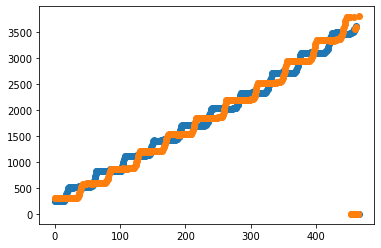

In [10]:
plt.scatter(np.arange(len(xL)), xL)
plt.scatter(np.arange(len(xL)), xR)
plt.show()

In [11]:
'''
preprocessing
'''

'\npreprocessing\n'

In [12]:
xL, xR, yL, yR, xL_toe, xR_toe, yL_toe, yR_toe = trim_zero(xL, xR, yL, yR, xL_toe, xR_toe, yL_toe, yR_toe)
xL, xR, yL, yR, t = interpolate_zero(xL, xR, yL, yR)
xL_toe, xR_toe, yL_toe, yR_toe, _ = interpolate_zero(xL_toe, xR_toe, yL_toe, yR_toe)

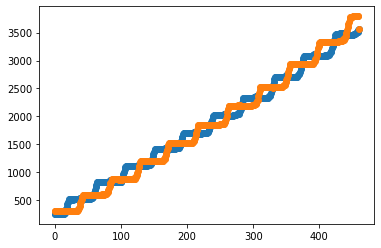

In [13]:
plt.scatter(np.arange(len(xL)), xL)
plt.scatter(np.arange(len(xL)), xR)
plt.show()

In [14]:
xL, yL = median5mean3Filter(xL, yL)
xR, yR = median5mean3Filter(xR, yR)
xL_toe, yL_toe = median5mean3Filter(xL_toe, yL_toe)
xR_toe, yR_toe = median5mean3Filter(xR_toe, yR_toe)

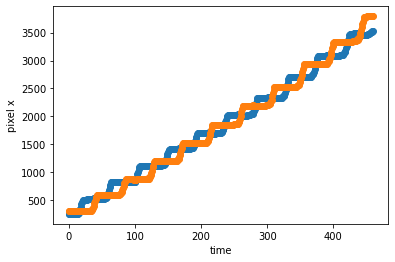

In [15]:
plt.scatter(np.arange(len(xL)), xL)
plt.scatter(np.arange(len(xL)), xR)
plt.ylabel('pixel x')
plt.xlabel('time')
plt.show()

In [16]:
'''
segment stopping and moving phase
'''

'\nsegment stopping and moving phase\n'

In [17]:
L_cluster = cluster(xL)
R_cluster = cluster(xR)
L_cluster_toe = cluster(xL_toe)
R_cluster_toe = cluster(xR_toe)

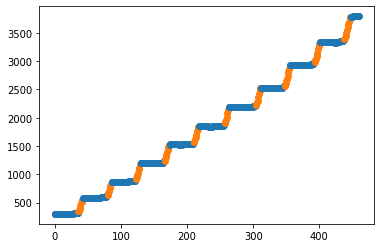

In [18]:
plot_cluster(xR, R_cluster)

In [19]:
'''
improve segmentation quality with postprocessing

* first do structure close and open on segmented graph
* pick better graph, evaluated with standard deviation of the slope
* convert all stopping phase label to 0 and moving phase label to 1
'''

'\nimprove segmentation quality with postprocessing\n\n* first do structure close and open on segmented graph\n* pick better graph, evaluated with standard deviation of the slope\n* convert all stopping phase label to 0 and moving phase label to 1\n'

In [20]:
from postprocess import pick_clustering, structure_close, structure_open, swap_label

L_cluster = pick_clustering(xL, [structure_close(L_cluster, 3), structure_open(L_cluster, 3)])
R_cluster = pick_clustering(xR, [structure_close(R_cluster, 3), structure_open(R_cluster, 3)])
L_cluster_toe = pick_clustering(xL_toe, [structure_close(L_cluster_toe, 3), structure_open(L_cluster_toe, 3)])
R_cluster_toe = pick_clustering(xR_toe, [structure_close(R_cluster_toe, 3), structure_open(R_cluster_toe, 3)])

L_cluster = swap_label(xL, L_cluster)
R_cluster = swap_label(xR, R_cluster)
L_cluster_toe = swap_label(xL_toe, L_cluster_toe)
R_cluster_toe = swap_label(xR_toe, R_cluster_toe)

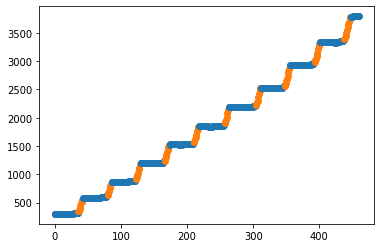

In [21]:
plot_cluster(xR, R_cluster)

In [22]:
from visualize import plot_multi_cluster

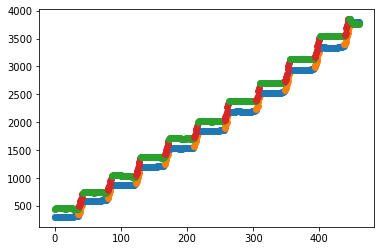

In [23]:
plot_multi_cluster([(xR, R_cluster), (xR_toe, R_cluster_toe)])

In [24]:
'''
switch left and right leg (in case it is swapped) evaluated via mean position in y-axis
and walking direction (leg closer to the camera have lower mean y-axis position)
'''

'\nswitch left and right leg (in case it is swapped) evaluated via mean position in y-axis\nand walking direction (leg closer to the camera have lower mean y-axis position)\n'

In [25]:
from postprocess import get_near_foot, correct_foot_side

near_foot = get_near_foot(xR)

L_bulk = [xL, xL_toe, yL_toe, L_cluster, L_cluster_toe]
R_bulk = [xR, xR_toe, yR_toe, R_cluster, R_cluster_toe]
yL, yR, L_bulk, R_bulk = correct_foot_side(yL, yR, L_bulk, R_bulk, near_foot=near_foot)
[xL, xL_toe, yL_toe, L_cluster, L_cluster_toe] = L_bulk
[xR, xR_toe, yR_toe, R_cluster, R_cluster_toe] = R_bulk

In [26]:
'''
extract important step for further feature extraction
'''

'\nextract important step for further feature extraction\n'

In [27]:
from feature_extraction import extract_phase_transition

phase_transition = []
phase_transition += extract_phase_transition(xR, yR, R_cluster, 'R', 'heel')
phase_transition += extract_phase_transition(xL, yL, L_cluster, 'L', 'heel')
phase_transition += extract_phase_transition(xR_toe, yR_toe, R_cluster_toe, 'R', 'toe')
phase_transition += extract_phase_transition(xL_toe, yL_toe, L_cluster_toe, 'L', 'toe')
phase_transition.sort(key = lambda x : x['frame'])

In [28]:
phase_transition[:6]

[{'frame': 15,
  'leg': 'L',
  'phase': 'lift',
  'Ximage': 265.447,
  'Yimage': 1560.71,
  'joint': 'heel'},
 {'frame': 16,
  'leg': 'L',
  'phase': 'lift',
  'Ximage': 471.515,
  'Yimage': 1572.5,
  'joint': 'toe'},
 {'frame': 21,
  'leg': 'L',
  'phase': 'place',
  'Ximage': 659.987,
  'Yimage': 1572.85,
  'joint': 'toe'},
 {'frame': 22,
  'leg': 'L',
  'phase': 'place',
  'Ximage': 501.06733333333324,
  'Yimage': 1578.6733333333334,
  'joint': 'heel'},
 {'frame': 36,
  'leg': 'R',
  'phase': 'lift',
  'Ximage': 347.607,
  'Yimage': 1584.6,
  'joint': 'heel'},
 {'frame': 37,
  'leg': 'R',
  'phase': 'lift',
  'Ximage': 494.981,
  'Yimage': 1666.69,
  'joint': 'toe'}]

In [29]:
'''
start matlab engine
'''

'\nstart matlab engine\n'

In [30]:
import matlab.engine

MATLAB = matlab.engine.start_matlab()

In [31]:
'''
detect chessboard corner for
* calibration to retrieve world distance
* trim video to entering => leaving the walk way
'''

'\ndetect chessboard corner for\n* calibration to retrieve world distance\n* trim video to entering => leaving the walk way\n'

In [32]:
from feature_extraction import detect_chessboard

square_size = 200 #millimeters
ret = detect_chessboard(filename, MATLAB, square_size)
if ret == 0:
    print('error detecting chessboard')

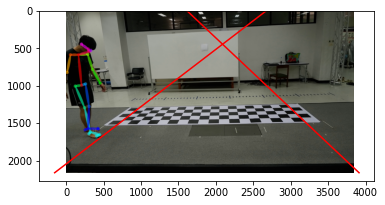

In [33]:
from visualize import plot_left_right_line
from feature_extraction import get_chessboard_corner, get_left_right_line, trim_phase_transition

corners, walkway_distance = get_chessboard_corner(square_size)
left_line, right_line = get_left_right_line(corners)
plot_left_right_line(filename, left_line, right_line)

In [34]:
f"walkway distance in side 2 lines = {walkway_distance/1000} meters"

'walkway distance in side 2 lines = 3.6 meters'

In [35]:
start_line = left_line
finish_line = right_line
if near_foot == 'L':
    start_line, finish_line = finish_line, start_line

In [36]:
phase_transition = trim_phase_transition(phase_transition, start_line, finish_line, near_foot)
phase_transition[0], phase_transition[-1]

({'frame': 21,
  'leg': 'L',
  'phase': 'place',
  'Ximage': 659.987,
  'Yimage': 1572.85,
  'joint': 'toe'},
 {'frame': 401,
  'leg': 'R',
  'phase': 'place',
  'Ximage': 3539.29,
  'Yimage': 1637.34,
  'joint': 'toe'})

In [37]:
'''
extract parameter
'''

'\nextract parameter\n'

In [38]:
from feature_extraction import getfps, get_walking_speed, get_cadence, get_step_info, get_stride_info, get_step_width,\
                               get_phase_duration, get_support_duration

In [39]:
fps = getfps(filename)

walking_speed = get_walking_speed(phase_transition, fps, walkway_distance)
cadence = get_cadence(phase_transition, fps)
L_step, R_step, L_step_time, R_step_time = get_step_info(phase_transition, fps, MATLAB)
L_stride, R_stride, L_stride_time, R_stride_time = get_stride_info(phase_transition, fps, MATLAB)
step_width = get_step_width(phase_transition, MATLAB)

cycle_duration, L_stance_mean, L_swing_mean, L_cycle_duration, L_stance_percentage, L_swing_percentage,\
R_stance_mean, R_swing_mean, R_cycle_duration, R_stance_percentage, R_swing_percentage = get_phase_duration(phase_transition, fps)

L_double_initial_mean, L_single_mean, L_double_initial_percentage, L_single_percentage, R_double_initial_mean,\
R_single_mean, R_double_initial_percentage, R_single_percentage = get_support_duration(phase_transition, fps)

In [40]:
result = f"""
--- some of the parameters ---

speed\t{walking_speed} m/s
width\t{step_width} cm
cycle time\t{cycle_duration} s

left step\t\t\tright step
{L_step} cm\t\t{R_step} cm
{L_step_time} s\t\t{R_step_time} s

left stance\t\t\tleft swing
{L_stance_mean} s\t\t{L_swing_mean} s

right stance\t\t\tright swing
{R_stance_mean} s\t\t{R_swing_mean} s

left stance\t\t\tright stance
{L_stance_mean} s\t\t{R_stance_mean} s

left swing\t\t\tright swing
{L_swing_mean} s\t\t{R_swing_mean} s

left cycle\t\t\tright cycle
{L_cycle_duration} s\t\t{R_cycle_duration} s

L steps/minute\t\t\tR steps/minute
{60/L_step_time}\t\t{60/R_step_time}

L strides/minute\t\tR strides/minute
{60/L_stride_time}\t\t{60/R_stride_time}

L dbl support\t\t\tR dbl support
{L_double_initial_mean} s\t\t{R_double_initial_mean} s
      """

print(result)

file = open(f"report/{filename}.txt", 'w+')
file.write(result)
file.close()


--- some of the parameters ---

speed	0.2839263157894737 m/s
width	18.64635512408088 cm
cycle time	1.4848181514848182 s

left step			right step
22.432753372192384 cm		21.581724039713542 cm
0.7257257257257257 s		0.760019278537797 s

left stance			left swing
1.2470804137470806 s		0.2335669002335669 s

right stance			right swing
1.2554220887554222 s		0.2335669002335669 s

left stance			right stance
1.2470804137470806 s		1.2554220887554222 s

left swing			right swing
0.2335669002335669 s		0.2335669002335669 s

left cycle			right cycle
1.4806473139806475 s		1.4889889889889891 s

L steps/minute			R steps/minute
82.67586206896551		78.94536585365854

L strides/minute		R strides/minute
40.52281690140845		40.183240223463685

L dbl support			R dbl support
0.5264523783042302 s		0.49215882549215884 s
      


In [ ]:
# def full(filename, MATLAB):
#     frames = load_frame(filename)
    
#     xL, yL = load_keypoints(frames, 21)
#     xR, yR = load_keypoints(frames, 24)
#     xL_toe, yL_toe = load_keypoints(frames, 19)
#     xR_toe, yR_toe = load_keypoints(frames, 22)
    
#     xL, xR, yL, yR, xL_toe, xR_toe, yL_toe, yR_toe = trim_zero(xL, xR, yL, yR, xL_toe, xR_toe, yL_toe, yR_toe)
#     xL, xR, yL, yR, t = interpolate_zero(xL, xR, yL, yR)
#     xL_toe, xR_toe, yL_toe, yR_toe, _ = interpolate_zero(xL_toe, xR_toe, yL_toe, yR_toe)
    
#     xL, yL = median5mean3Filter(xL, yL)
#     xR, yR = median5mean3Filter(xR, yR)
#     xL_toe, yL_toe = median5mean3Filter(xL_toe, yL_toe)
#     xR_toe, yR_toe = median5mean3Filter(xR_toe, yR_toe)
    
#     L_cluster = cluster(xL)
#     R_cluster = cluster(xR)
#     L_cluster_toe = cluster(xL_toe)
#     R_cluster_toe = cluster(xR_toe)
    
#     L_cluster = pick_clustering(xL, [structure_close(L_cluster, 3), structure_open(L_cluster, 3)])
#     R_cluster = pick_clustering(xR, [structure_close(R_cluster, 3), structure_open(R_cluster, 3)])
#     L_cluster_toe = pick_clustering(xL_toe, [structure_close(L_cluster_toe, 3), structure_open(L_cluster_toe, 3)])
#     R_cluster_toe = pick_clustering(xR_toe, [structure_close(R_cluster_toe, 3), structure_open(R_cluster_toe, 3)])

#     L_cluster = swap_label(xL, L_cluster)
#     R_cluster = swap_label(xR, R_cluster)
#     L_cluster_toe = swap_label(xL_toe, L_cluster_toe)
#     R_cluster_toe = swap_label(xR_toe, R_cluster_toe)
    
#     near_foot = get_near_foot(xR)

#     L_bulk = [xL, xL_toe, yL_toe, L_cluster, L_cluster_toe]
#     R_bulk = [xR, xR_toe, yR_toe, R_cluster, R_cluster_toe]
#     yL, yR, L_bulk, R_bulk = correct_foot_side(yL, yR, L_bulk, R_bulk, near_foot=near_foot)
#     [xL, xL_toe, yL_toe, L_cluster, L_cluster_toe] = L_bulk
#     [xR, xR_toe, yR_toe, R_cluster, R_cluster_toe] = R_bulk
    
#     phase_transition = []
#     phase_transition += extract_phase_transition(xR, yR, R_cluster, 'R', 'heel')
#     phase_transition += extract_phase_transition(xL, yL, L_cluster, 'L', 'heel')
#     phase_transition += extract_phase_transition(xR_toe, yR_toe, R_cluster_toe, 'R', 'toe')
#     phase_transition += extract_phase_transition(xL_toe, yL_toe, L_cluster_toe, 'L', 'toe')
#     phase_transition.sort(key = lambda x : x['frame'])
    
#     square_size = 200 #millimeters
#     ret = detect_chessboard(filename, MATLAB, square_size)
    
#     corners, walkway_distance = get_chessboard_corner(square_size)
#     left_line, right_line = get_left_right_line(corners)
    
#     start_line = left_line
#     finish_line = right_line
#     if near_foot == 'L':
#         start_line, finish_line = finish_line, start_line
        
#     phase_transition = trim_phase_transition(phase_transition, start_line, finish_line, near_foot)
#     phase_transition[0], phase_transition[-1]
    
#     fps = getfps(filename)

#     walking_speed = get_walking_speed(phase_transition, fps, walkway_distance)
#     cadence = get_cadence(phase_transition, fps)
#     L_step, R_step, L_step_time, R_step_time = get_step_info(phase_transition, fps, MATLAB)
#     L_stride, R_stride, L_stride_time, R_stride_time = get_stride_info(phase_transition, fps, MATLAB)
#     step_width = get_step_width(phase_transition, MATLAB)

#     cycle_duration, L_stance_mean, L_swing_mean, L_cycle_duration, L_stance_percentage, L_swing_percentage,\
#     R_stance_mean, R_swing_mean, R_cycle_duration, R_stance_percentage, R_swing_percentage = get_phase_duration(phase_transition, fps)

#     L_double_initial_mean, L_single_mean, L_double_initial_percentage, L_single_percentage, R_double_initial_mean,\
#     R_single_mean, R_double_initial_percentage, R_single_percentage = get_support_duration(phase_transition, fps)
    
#     result = f"""
#     --- some of the parameters ---

#     speed\t{walking_speed} m/s
#     width\t{step_width} cm
#     cycle time\t{cycle_duration} s

#     left step\t\t\tright step
#     {L_step} cm\t\t{R_step} cm
#     {L_step_time} s\t\t{R_step_time} s

#     left stance\t\t\tleft swing
#     {L_stance_mean} s\t\t{L_swing_mean} s

#     right stance\t\t\tright swing
#     {R_stance_mean} s\t\t{R_swing_mean} s

#     left stance\t\t\tright stance
#     {L_stance_mean} s\t\t{R_stance_mean} s

#     left swing\t\t\tright swing
#     {L_swing_mean} s\t\t{R_swing_mean} s

#     left cycle\t\t\tright cycle
#     {L_cycle_duration} s\t\t{R_cycle_duration} s

#     L steps/minute\t\t\tR steps/minute
#     {60/L_step_time}\t\t{60/R_step_time}

#     L strides/minute\t\tR strides/minute
#     {60/L_stride_time}\t\t{60/R_stride_time}

#     L dbl support\t\t\tR dbl support
#     {L_double_initial_mean} s\t\t{R_double_initial_mean} s
#           """
    
#     file = open(f"report/{filename}.txt", 'w+')
#     file.write(result)
#     file.close()
    
# MATLAB = matlab.engine.start_matlab()
# filenames = ['injured-1', 'fastwalk-1', 'leglead-1', 'parkinson-1', 'normal-1', 'normal-2', 'normal-3']
# for fn in filenames:
#     full(fn, MATLAB)